In [1]:
%matplotlib notebook

import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
def calculateTailSpeed(tailposition, tf, history):
    tailSpeed = np.zeros((np.shape(tailposition)[0],), dtype=np.float)
    tailDisplacement = np.zeros((np.shape(tailposition)[0],), dtype=np.float)
    x = (tailposition[history:, 0] - tailposition[:-history, 0])**2
    y = (tailposition[history:, 1] - tailposition[:-history, 1])**2
    tailDisplacement[history:] = np.sqrt(x + y).copy()
    tailDisplacement = jump_stitcher_anyMetric(tailDisplacement, 0)
    tailSpeed[history:] = tailDisplacement[history:]/np.asarray(history*tf, dtype=np.float)
    tailSpeed = jump_stitcher_anyMetric(tailSpeed, 0)
    return tailSpeed, tailDisplacement

def smoothen_savgol(dat, window_size, polyOrder):
    dat_filt = savgol_filter(dat, window_size, polyOrder, mode='nearest')
    return dat_filt

def jump_stitcher_anyMetric(incorrectVar, plot_flag):
    incorrectVar_diff = np.diff(incorrectVar)
    if incorrectVar_diff.size:
        diff_cutoff = np.percentile(incorrectVar_diff, 99)*10;

        out_of_bound_max_cutoff = np.percentile(incorrectVar,99)+(np.percentile(incorrectVar,99)-np.percentile(incorrectVar,1))/2
        out_of_bound_min_cutoff = np.percentile(incorrectVar,1)-(np.percentile(incorrectVar,99)-np.percentile(incorrectVar,1))/2

        out_of_bound_index = np.where((incorrectVar>out_of_bound_max_cutoff) | (incorrectVar<out_of_bound_min_cutoff))
        out_of_bound_index = np.asarray(out_of_bound_index).flatten()
        discontinuity_index = np.array([-1])

        for i in range(0, len(incorrectVar_diff)):
            if np.abs(incorrectVar_diff[i]) > diff_cutoff:
                discontinuity_index = [discontinuity_index, (i-1), i, (i+1)]

        discontinuity_index = np.unique(discontinuity_index[discontinuity_index > 0])

        incorrectVar_nan = incorrectVar
        incorrectVar_nan[np.union1d(out_of_bound_index,discontinuity_index)] = np.nan
#         correctedVar = pd.Series(incorrectVar_nan).interpolate(method='pchip').ffill().bfill().as_matrix()
        correctedVar = pd.Series(incorrectVar_nan).interpolate(method='linear').as_matrix()        
#         correctedVar = pchip_interpolate(np.arange(0, len(incorrectVar_nan)), 
#                                          incorrectVar_nan, np.arange(0, len(incorrectVar_nan)))

        if plot_flag == 1:
            fig = plt.figure(figsize=(15, 8))
            plt.plot(np.arange(0, len(incorrectVar_nan[1000:1300])), incorrectVar_nan[1000:1300], color='k')
            plt.plot(np.arange(0, len(correctedVar[1000:1300])), 2+correctedVar[1000:1300], 'r')
            plt.show()
    else:
        correctedVar = incorrectVar

    return correctedVar

def readSplineData(fNameIn, nFrames):

    splineX = np.full((nFrames, 101), fill_value=np.nan, dtype=np.uint16);
    splineY = np.full((nFrames, 101), fill_value=np.nan, dtype=np.uint16);
    frameNumber = np.full((nFrames, 1), fill_value=np.nan, dtype=np.uint16);
    unknown = np.full((nFrames, 1), fill_value=np.nan, dtype=np.uint16);
    unknown_2 = np.full((nFrames, 1), fill_value=np.nan, dtype=np.uint16);
    fCount = -1;

    with open(fileName, "rb") as f:
        while (True) and (fCount < nFrames-1):
            fCount = fCount+1
            buff = f.read(struct.calcsize('>iHH'))
            unknown[fCount], unknown_2[fCount], frameNumber[fCount] = struct.unpack('>iHH', buff)

            nPointsToRead =  struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" % (nPointsToRead)
            temp = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
            if len(temp) > 0:
                splineX[fCount, :] = temp

            nPointsToRead =  struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" % (nPointsToRead)
            temp = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
            if len(temp) > 0:
                splineY[fCount, :] = temp

    return frameNumber, splineX, splineY        

In [3]:

fileName_metaData = "/Volumes/GoogleDrive/My Drive/CRG_Dropbox/AljoComputer/Matlab/high_res_tracker/Data/20180506_iav_GTACR_Midpoint_600_micron_GreenLight/CSV/Metadata_20180506_202514.txt"
df = pd.read_csv(fileName_metaData, sep=',')
df.columns = ['frame_num', 'time', 'stage_x','stage_y', 'centroid_x','centroid_y', 'midpoint_x','midpoint_y',
              'head_x','head_y', 'tail_x','tail_y', 'f1_x','f1_y', 'f2_x','f2_y', 'f3_x','f3_y', 'f4_x','f4_y',
              'f5_x','f5_y', 'f6_x','f6_y', 'f7_x','f7_y', 'f8_x','f8_y', 'f9_x','f9_y', 'f10_x','f10_y',
              'f11_x','f11_y', 'f12_x','f12_y', 'f13_x','f13_y', 'f14_x','f14_y', 'f15_x','f15_y', 'f16_x','f16_y',
              'f1_max', 'f2_max', 'f3_max', 'f4_max', 'f5_max', 'f6_max', 'f7_max', 'f8_max','f8_max', 'f10_max',
              'f11_max', 'f12_max', 'f13_max', 'f14_max', 'f15_max', 'f16_max', 'num_key_points']
total_frames = df.shape[0]
df.head()

,frame_num,time,stage_x,stage_y,centroid_x,centroid_y,midpoint_x,midpoint_y,head_x,head_y,...,f8_max,f8_max,f10_max,f11_max,f12_max,f13_max,f14_max,f15_max,f16_max,num_key_points
0,19062,0,254.074,194.519,0,0,880,977,680,1707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,19063,1,254.074,194.519,0,0,884,973,684,1706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,19064,9,254.073,194.520,0,0,887,961,683,1690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,19065,17,254.074,194.520,0,0,905,927,703,1679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,19066,30,254.073,194.519,0,0,904,929,701,1658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
fileName = "/Volumes/GoogleDrive/My Drive/CRG_Dropbox/AljoComputer/Matlab/high_res_tracker/Data/20180506_iav_GTACR_Midpoint_600_micron_GreenLight/CSV/SPLINE_20180506_202514.bin"
frameNumber, splineX, splineY = readSplineData(fileName, total_frames)
print np.shape(splineX)
print np.shape(splineY)

(37629, 101)
(37629, 101)


In [5]:
segment_boundries = np.round(np.arange(0.0, 101.0, (100.0/11.0))).astype(int)

splineX_segBound = ((splineX[:, segment_boundries]*0.0275).T + df.stage_x.values).T
splineY_segBound = ((splineY[:, segment_boundries]*0.0275).T + df.stage_y.values).T

print np.shape(splineX_segBound)
print np.shape(splineY_segBound)

(37629, 12)
(37629, 12)


In [6]:
plt.plot(splineX_segBound[:, 5], splineY_segBound[:, 5])

<IPython.core.display.Javascript object>

In [23]:
tf = 0.008
window = 11
temp_pos = np.array([splineX_segBound[:, 11], splineY_segBound[:, 11]], dtype=np.float16).T
temp_speed_1, temp_displacement_1 = calculateTailSpeed(temp_pos, tf, window)

temp_pos = np.array([splineX_segBound[:, 0], splineY_segBound[:, 0]], dtype=np.float16).T
temp_speed_2, temp_displacement_2 = calculateTailSpeed(temp_pos, tf, window)

<IPython.core.display.Javascript object>


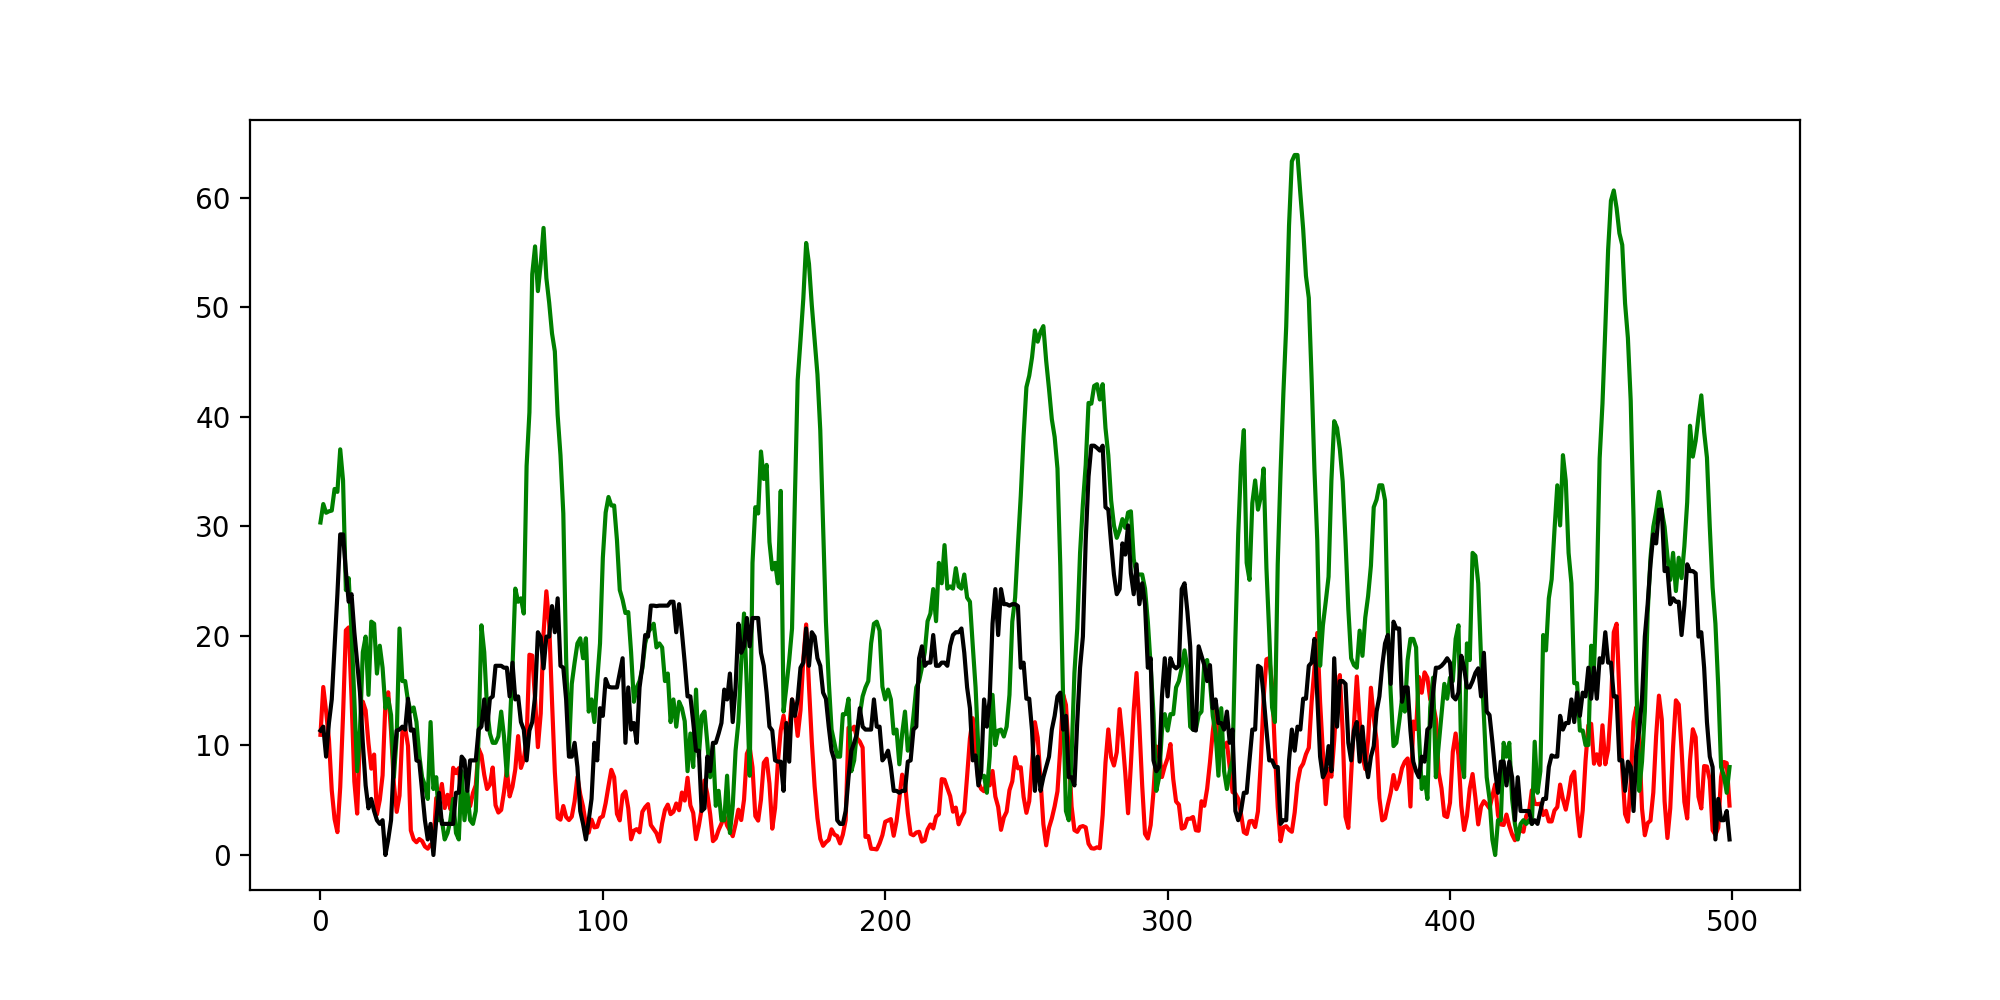

In [42]:
plt.figure(figsize=(10, 5))
# plt.plot(np.cumsum(temp_displacement_1[1000:2000]))
# plt.plot(np.cumsum(temp_displacement_2[1000:2000]))
# plt.plot(temp_speed_1[1625:2125], 'r')
s = e
e = s + 500
plt.plot(axial_comp_speed_filt[s:e, 0], 'r')
plt.plot(temp_speed_2[s:e], 'g')
plt.plot(temp_speed_1[s:e], 'k')
# plt.xlim([300, 600])
# plt.ylim([160, 660])

In [9]:
## head - 0, midpoint - 6, tail - 11
axial_comp_x = np.zeros_like(splineX_segBound)
axial_comp_y = np.zeros_like(splineY_segBound)
axial_comp_speed = np.zeros_like(splineY_segBound)
axial_comp_speed_filt = np.zeros_like(splineY_segBound)
axial_comp_displacement = np.zeros_like(splineY_segBound)
axial_comp_displacement_filt = np.zeros_like(splineY_segBound)

tf = 0.008
window = 3
polyOrder = 1
for j in range(0, np.shape(splineX_segBound)[1]):
    for i in range(0, total_frames-1):
        h0 = np.array([splineX_segBound[i, 0], splineY_segBound[i, 0]])
        m0 = np.array([splineX_segBound[i, 6], splineY_segBound[i, 6]])
        m0h0_vec = h0 - m0
        
#         t0 = np.array([splineX_segBound[i, 11], splineY_segBound[i, 11]])
#         m0 = np.array([splineX_segBound[i, 6], splineY_segBound[i, 6]])
#         m0h0_vec = m0 - t0
        
        h0 = np.array([splineX_segBound[i, j], splineY_segBound[i, j]])
        h1 = np.array([splineX_segBound[i+1, j], splineY_segBound[i+1, j]])
        h0h1_vector = h1 - h0

        abs_m0h0_vec = np.linalg.norm(m0h0_vec)
        dot_h0h1_m0h0_vec = np.dot(h0h1_vector, m0h0_vec)
        factor_axial_component = dot_h0h1_m0h0_vec/(abs_m0h0_vec**2)
        h1_axial_component = factor_axial_component*m0h0_vec
        axial_comp_x[i+1, j] = h1_axial_component[0]
        axial_comp_y[i+1, j] = h1_axial_component[1]

    temp_pos = np.array([axial_comp_x[:, j], axial_comp_y[:, j]], dtype=np.float16).T
    temp_speed, temp_displacement = calculateTailSpeed(temp_pos, tf, window) 
    
    axial_comp_speed[:, j] = temp_speed
    axial_comp_speed_filt[:, j] = smoothen_savgol(temp_speed, window, polyOrder)
    
    axial_comp_displacement[:, j] = temp_displacement
    axial_comp_displacement_filt[:, j] = smoothen_savgol(temp_displacement, window, polyOrder)

/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


In [10]:
plt.figure()
plt.plot(axial_comp_x[:, 0], axial_comp_y[:, 0])
plt.plot(axial_comp_x[:, 6], axial_comp_y[:, 6])
plt.plot(axial_comp_x[:, 11], axial_comp_y[:, 11])
plt.xlim([7200, 8200])

<IPython.core.display.Javascript object>

(7200, 8200)

In [11]:
plt.figure()
for i in range(0, 12):
    plt.plot(axial_comp_speed_filt[15000:15500, i])

plt.legend(('Head', 'T1', 'T2', 'T3', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'T'), loc='upper right')
# plt.xlim([15000, 15500])

<IPython.core.display.Javascript object>

In [12]:
axial_comp_speed_filt_norm = (axial_comp_speed_filt.T - axial_comp_speed_filt[:, -1]).T

In [13]:
plt.figure()
for i in range(0, 12):
    plt.plot(axial_comp_speed_filt_norm[:, i])

plt.legend(('Head', 'T1', 'T2', 'T3', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'T'), loc='upper right')

<IPython.core.display.Javascript object>

In [14]:
plt.figure()
for i in range(0, 12):
    plt.plot(np.cumsum(axial_comp_displacement[15250:15375, i]))

plt.legend(('Head', 'T1', 'T2', 'T3', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'T'), loc='best')
# plt.xlim([15000, 15500])

<IPython.core.display.Javascript object>

In [15]:
## Below code describes how to calculate a component of a vector
head_0 = np.array([1, 1])
midpoint_0 = np.array([0, 0])
m0h0_vec = head_0 - midpoint_0

print "head_0 - ", head_0
print "midpoint - ", midpoint_0
print "m0h0_vec - ", m0h0_vec

head_1 = np.array([1, 1])
m0h1_vector = head_1 - midpoint_0
print "head_1 - ", head_1
print "m0h1_vector - ", m0h1_vector

abs_m0h0_vec = np.linalg.norm(m0h0_vec)
dot_m0h1_m0h0_vec = np.dot(m0h1_vector, m0h0_vec)
factor_axial_component = dot_m0h1_m0h0_vec/(abs_m0h0_vec**2)
h1_axial_component = factor_axial_component*m0h0_vec

print "abs_mh_vec - ", abs_m0h0_vec
print "dot_mh_h0_h1_vec - ", dot_m0h1_m0h0_vec
print "head_axial_component - ", h1_axial_component

print '\n\nAfter rotation... 30'
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.matrix([[c, -s], [s, c]])

head_30 = head_1*R
m0h1_vector = head_30 - midpoint_0
print "head_1 - ", head_30
print "m0h1_vector - ", m0h1_vector

abs_m0h0_vec = np.linalg.norm(m0h0_vec)
dot_m0h1_m0h0_vec = np.dot(m0h1_vector, m0h0_vec)
factor_axial_component = dot_m0h1_m0h0_vec/(abs_m0h0_vec**2)
h1_axial_component = factor_axial_component*m0h0_vec
print "abs_mh_vec - ", abs_m0h0_vec
print "dot_mh_h0_h1_vec - ", dot_m0h1_m0h0_vec
print "head_axial_component - ", h1_axial_component

print '\n\nAfter rotation... 60'
theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.matrix([[c, -s], [s, c]])

head_60 = head_1*R
m0h1_vector = head_60 - midpoint_0
print "head_1 - ", head_60
print "m0h1_vector - ", m0h1_vector

abs_m0h0_vec = np.linalg.norm(m0h0_vec)
dot_m0h1_m0h0_vec = np.dot(m0h1_vector, m0h0_vec)
factor_axial_component = dot_m0h1_m0h0_vec/(abs_m0h0_vec**2)
h1_axial_component = factor_axial_component*m0h0_vec
print "abs_mh_vec - ", abs_m0h0_vec
print "dot_mh_h0_h1_vec - ", dot_m0h1_m0h0_vec
print "head_axial_component - ", h1_axial_component

print '\n\nAfter rotation... 90'
theta = np.radians(90)
c, s = np.cos(theta), np.sin(theta)
R = np.matrix([[c, -s], [s, c]])

head_90 = head_1*R
m0h1_vector = head_90 - midpoint_0
print "head_1 - ", head_90
print "m0h1_vector - ", m0h1_vector

abs_m0h0_vec = np.linalg.norm(m0h0_vec)
dot_m0h1_m0h0_vec = np.dot(m0h1_vector, m0h0_vec)
factor_axial_component = dot_m0h1_m0h0_vec/(abs_m0h0_vec**2)
h1_axial_component = factor_axial_component*m0h0_vec
print "abs_mh_vec - ", abs_m0h0_vec
print "dot_mh_h0_h1_vec - ", dot_m0h1_m0h0_vec
print "head_axial_component - ", h1_axial_component

# for i in range(0, total_frames-1):
#     midpoint_head_vector = 
#     temp_speed = np.array([splineX_segBound[:, 5], splineY_segBound[:, 5]], dtype=np.float16).T
#     

head_0 -  [1 1]
midpoint -  [0 0]
m0h0_vec -  [1 1]
head_1 -  [1 1]
m0h1_vector -  [1 1]
abs_mh_vec -  1.41421356237
dot_mh_h0_h1_vec -  2
head_axial_component -  [ 1.  1.]


After rotation... 30
head_1 -  [[ 1.3660254  0.3660254]]
m0h1_vector -  [[ 1.3660254  0.3660254]]
abs_mh_vec -  1.41421356237
dot_mh_h0_h1_vec -  [[ 1.73205081]]
head_axial_component -  [[ 0.8660254  0.8660254]]


After rotation... 60
head_1 -  [[ 1.3660254 -0.3660254]]
m0h1_vector -  [[ 1.3660254 -0.3660254]]
abs_mh_vec -  1.41421356237
dot_mh_h0_h1_vec -  [[ 1.]]
head_axial_component -  [[ 0.5  0.5]]


After rotation... 90
head_1 -  [[ 1. -1.]]
m0h1_vector -  [[ 1. -1.]]
abs_mh_vec -  1.41421356237
dot_mh_h0_h1_vec -  [[  1.11022302e-16]]
head_axial_component -  [[  5.55111512e-17   5.55111512e-17]]


In [16]:
segment_boundries = np.round(np.arange(0.0, 101.0, (100.0/11.0))).astype(int)
segment_boundries

array([  0,   9,  18,  27,  36,  45,  55,  64,  73,  82,  91, 100])

In [17]:
0 T1 9 T2 18 T3 27 A1 36 A2 45 A3 55 A4 64 A5 73 A6 82 A7 91 A8/9 100/T

SyntaxError: invalid syntax (<ipython-input-17-58935bbc3d1e>, line 1)

In [ ]:
pd.DataFrame(np.array([temp_displacement, np.cumsum(temp_displacement)]).T)
plt.figure()
plt.plot(temp_displacement)
plt.plot(np.cumsum(temp_displacement))